# Overview
Use this notebook to convert an OCT image you have to a virtual H&E image for evaluation.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/zero_shot_segmentation/blob/main/zero_shot_segmentation_oct.ipynb)
 and run.


# inputs

Assumptions:

oct scan x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 1

pix2pix input sizes:
*   virtual histology input width = 256
*   virtual histology input height = 256

pix2pix input x/z rates:
*   microns per pixel z = 1
*   microns per pixel x = 2

In [1]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Emilie/z-stacking/croppedimage2.png"


In [2]:
#cropping params
width = 256 * 4
height = 256 * 2
x0 = 135
z0= 350

In [3]:
#visualization of virtual histology
visualize_oct2hist_outputs = False
#visualization size
FIG_SIZE = (10,5)

In [4]:
#rf - roboflow dataset related params
rf_api_key="R04BinsZcBZ6PsfKR2fP"
rf_workspace="yolab-kmmfx"
rf_project = "connect_from_colab"
rf_dataset = "png-mask-semantic"

In [5]:
#segment anything (sam)
using_colab = True
visualize_sam_outputs = True

#sam algorithm input parameters
points_per_side=32
pred_iou_thresh=0.90
stability_score_thresh=0.95
crop_n_layers=1
crop_n_points_downscale_factor=2
min_mask_region_area=3000

#sam model type and weights checkpoint
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

#Zero shot pipeline

In [6]:
import torch
import torchvision
import os

# Clone repository, run setup on first load
if not 'setup_env_oct2Hist_usemodel' in globals():
  setup_env_oct2Hist_usemodel = True
  !git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel
  %run /content/OCT2Hist-UseModel/setup_env.ipynb



Cloning into 'OCT2Hist-UseModel'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 337 (delta 41), reused 10 (delta 4), pack-reused 270
Receiving objects: 100% (337/337), 9.56 MiB | 26.31 MiB/s, done.
Resolving deltas: 100% (195/195), done.
Submodule 'pytorch-CycleGAN-and-pix2pix' (https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) registered for path 'pytorch-CycleGAN-and-pix2pix'
Cloning into '/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.        
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513        
Receiving objects: 100% (2513/2513), 8.20 MiB | 25.82 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Submodule path 'pytorch-CycleGAN-and-pix2pix': checked out '9f8f61e5a375c2e01c5187d093ce9c2409f409b0'
Mounted at /content/drive/
/content/OCT2Hist-UseModel
Drive already mounted at /content/drive/; to

In [7]:
#go back to initial dir
%cd "/content"
!git clone --recurse-submodules https://github.com/WinetraubLab/zero_shot_segmentation.git


/content
Cloning into 'zero_shot_segmentation'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 112 (delta 44), reused 60 (delta 13), pack-reused 0
Receiving objects: 100% (112/112), 8.26 MiB | 24.94 MiB/s, done.
Resolving deltas: 100% (44/44), done.


In [8]:
# !rm -rf "/content/zero_shot_segmentation"

In [9]:
%pip install dataclasses-json
%pip install supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.9 MB/s eta 0:00:00


In [10]:
from zero_shot_segmentation.zero_shot_utils.utils import *

Did not crop, image is too small.


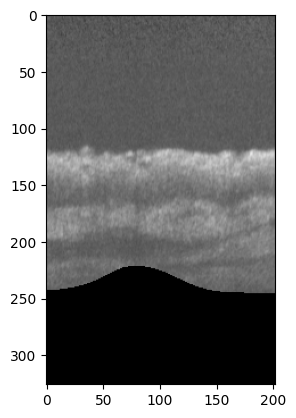

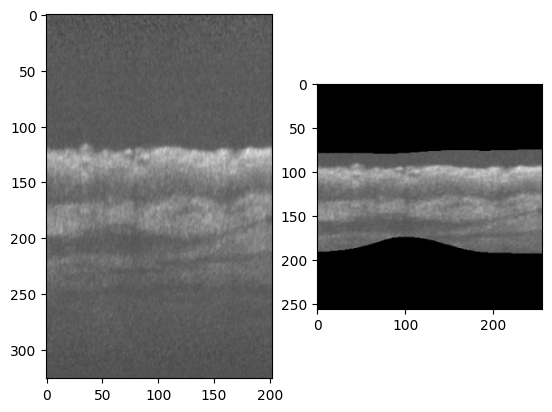

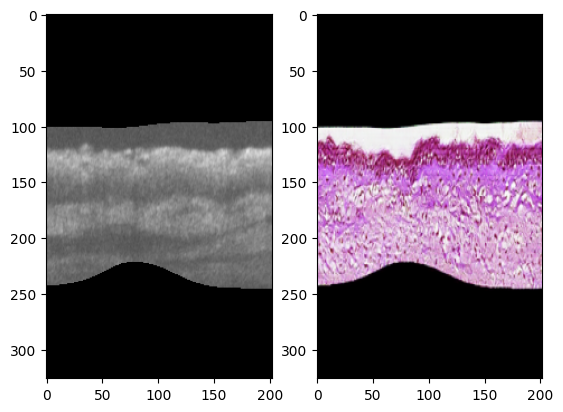

In [47]:
%run /content/OCT2Hist-UseModel/ConvertOCTImagesToHistology.ipynb

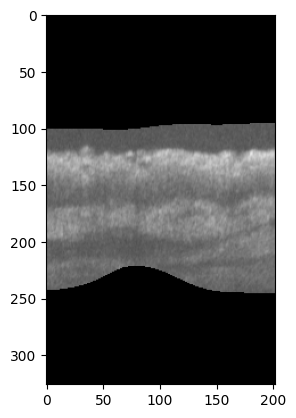

In [48]:
showImg(cropped)

#run sam on virtual histology

## Environment Set-up

In [13]:
%run /content/zero_shot_segmentation/setup_roboflow_and_sam.ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=61d4731b77cc8bf028514653b14496c1d2b1fea021cdaf6eb4ec08a4c0eab453
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: idna
    Found 

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to connect_from_colab-1 in png-mask-semantic:: 100%|██████████| 6/6 [00:00<00:00, 3326.17it/s]

/content/connect_from_colab-1/test
/content/connect_from_colab-1/test/_annotations.coco.json
PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-x23f3wqz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-x23f3wqz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=d48ef3987aad788f05c9c5f25ddd3b62e631c2960666812f96254e3028807172
  Stored in directory: /tmp/pip-ephem-wheel-cache-_3k90hgg/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-08-30 18:11:39--  https://pbs.twimg.com/media/FvpQj7UWYAAgxfo?format=jpg
Resolving pbs.twimg.com (pbs.twimg.com)... 72.21.91.70, 2606:2800:220:1410:489:141e:20bb:12f6
Connecting to pbs.twimg.com (pbs.twimg.com)|72.21.91.70|:443... connected.
HTTP request sent, awai

To generate masks, just run `generate` on an image.

In [14]:
masks = mask_generator.generate(virtual_histology_image_resized)

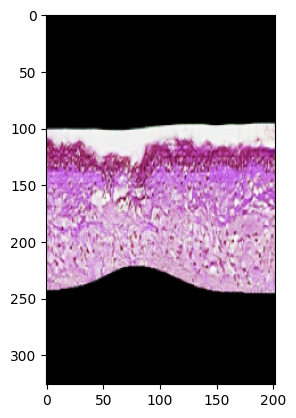

In [15]:
showImg(virtual_histology_image_resized)

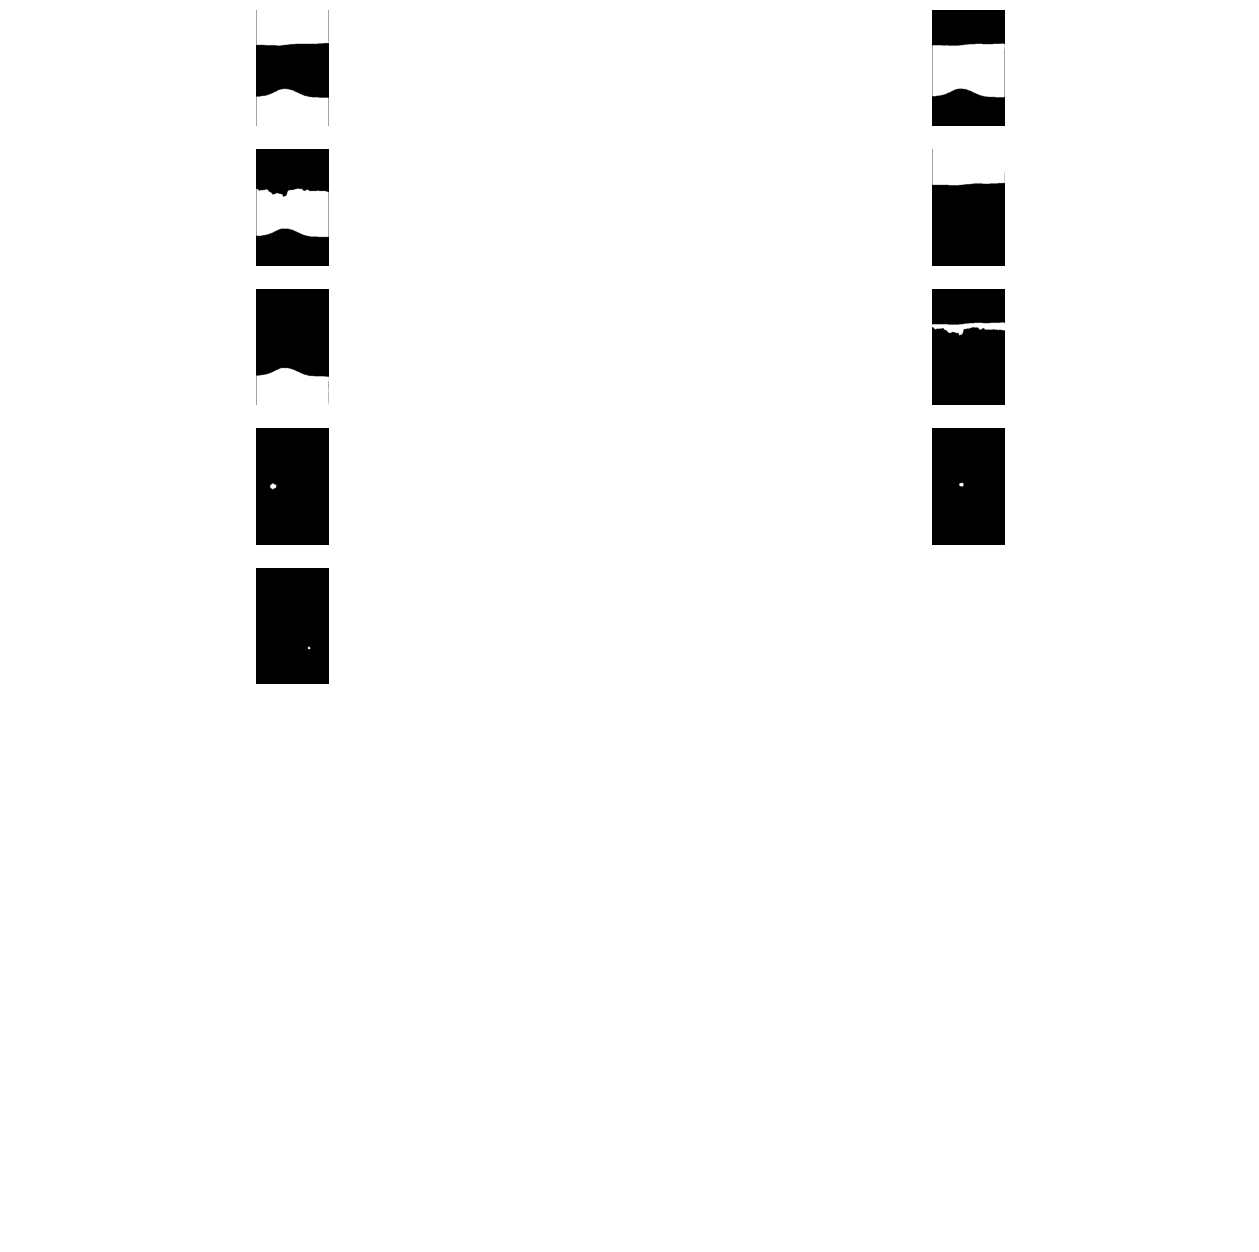

In [16]:
if visualize_sam_outputs:
  visualize_masks(masks)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

Show all the masks overlayed on the image.

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:[link text](https://)


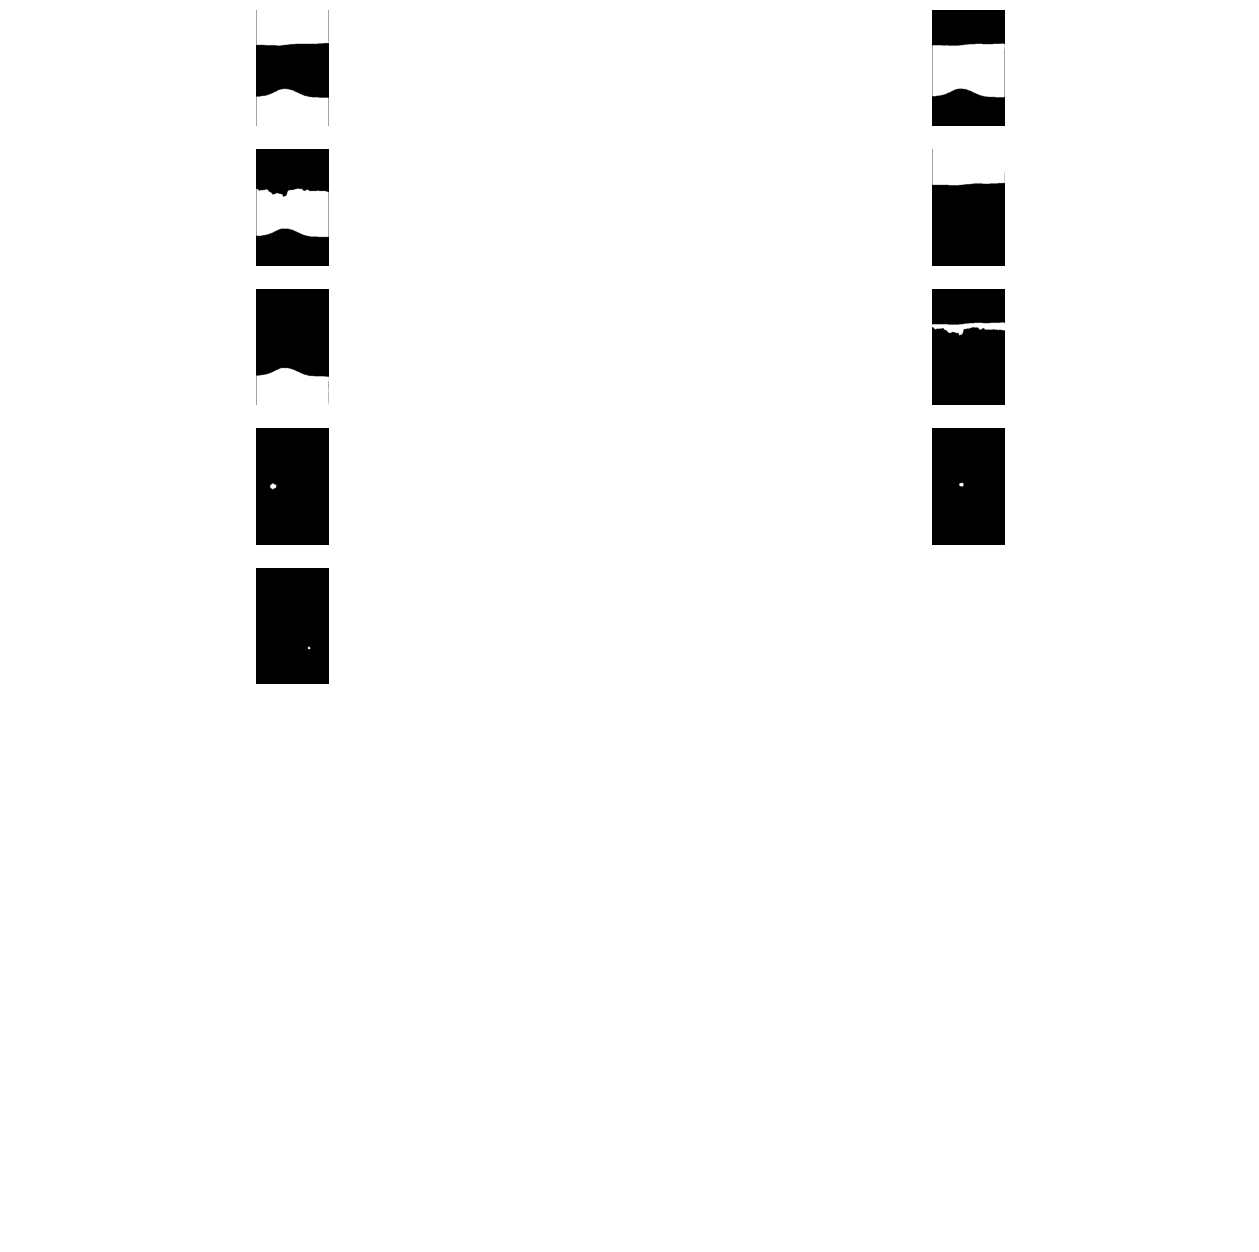

In [17]:
if visualize_sam_outputs:
  visualize_masks(masks)

#project on oct

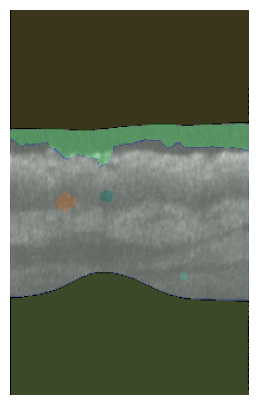

In [49]:
visualize_masks_on_img(cropped, masks, FIG_SIZE)

In [68]:
from copy import deepcopy
cropped_copy = deepcopy(cropped)
#mask out the pixels that are part of the skin delineation.
cropped_copy[masks[4]['segmentation'] == True] = 0

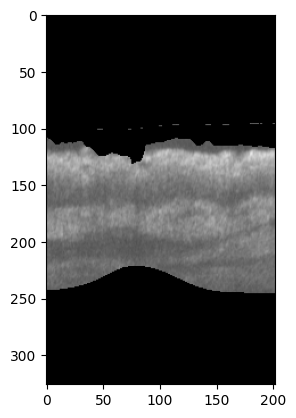

In [69]:
showImg(cropped_copy)